# 目的

- https://github.com/interpretml/interpret

- 説明可能AIの調査
    - https://www.slideshare.net/SatoshiHara3/ss-126157179
    - https://christophm.github.io/interpretable-ml-book/

- SHAPとGA2Mはどちらが説明性が高いか調査する。

In [1]:
import os
from pathlib import Path
import re
import multiprocessing
import subprocess
import concurrent.futures as fu
import gc
import json

import pandas as pd
import pandas_profiling as pdp
import numpy as np
from tqdm import tqdm_notebook as tqdm

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st


import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['font.family'] = 'IPAPGothic'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# import sys
# sys.path.append('../utils')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# カラム内の文字数
pd.set_option("display.max_colwidth", 200)
#行数
pd.set_option("display.max_rows", 200)

%matplotlib inline

# 0. data import

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
data = load_breast_cancer()

In [4]:
dir(data)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']

In [5]:
df = pd.DataFrame(data=data.data, columns=data.feature_names)

# 1. data visualizing

In [6]:
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error  worst radius  worst texture  worst perimeter  worst area  worst smoothness  worst compactness  worst concavity  worst concave points  worst symmetry  worst fractal dimension
0        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871        1.0950         0.9053            8.589      153.40          0.006399            0.04904          0.05373               0.01587         0.03003                 0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890
1        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667        0.5435         0.7339            3.398       74.08          0.005225            0.01308          0.01860               0.01340         0.01389                 0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902
2        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999        0.7456         0.7869            4.585       94.03          0.006150            0.04006          0.03832               0.02058         0.02250                 0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758
3        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744        0.4956         1.1560            3.445       27.23          0.009110            0.07458          0.05661               0.01867         0.05963                 0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300
4        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883        0.7572         0.7813            5.438       94.44          0.011490            0.02461          0.05688               0.01885         0.01756                 0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678

In [7]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [8]:
df['target']=data.target

In [9]:
df.shape

(569, 31)

In [10]:
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [11]:
pdp.ProfileReport(df)

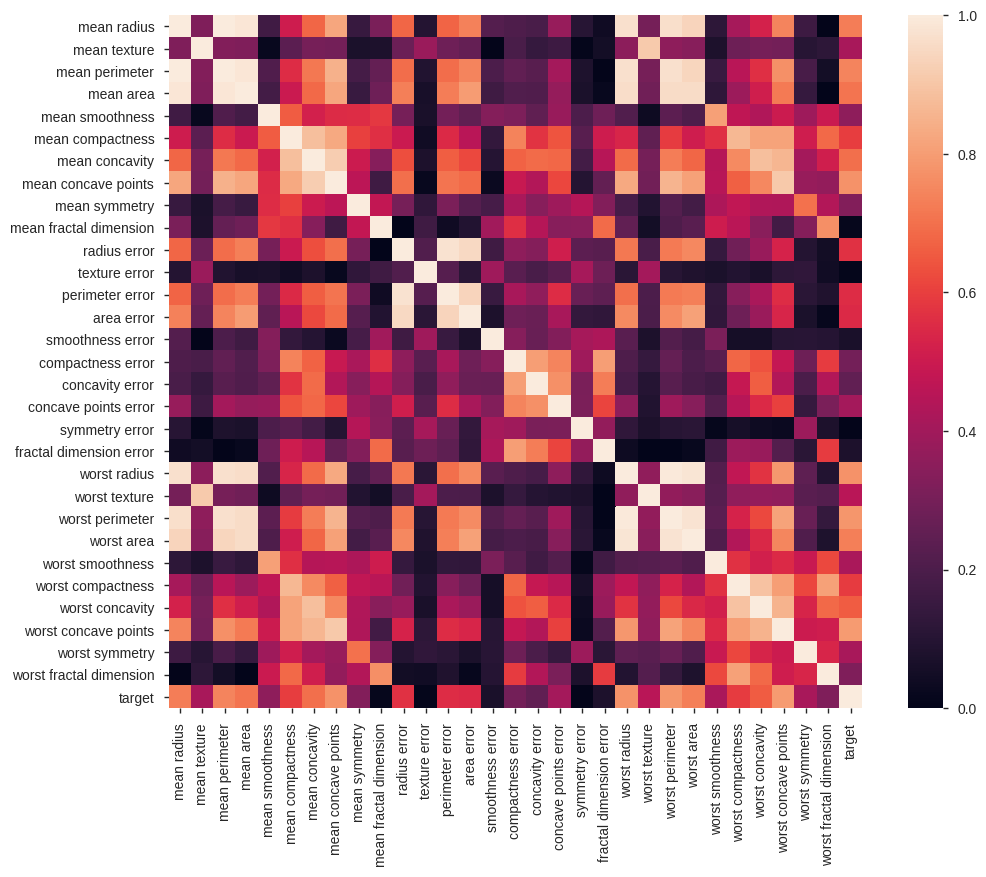

In [12]:
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(corrmat), vmin=0, vmax=1, square=True)
plt.show()

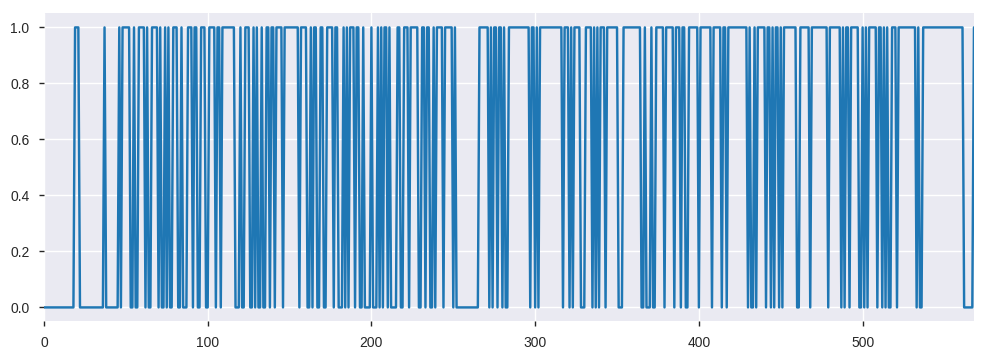

In [13]:
plt.figure(figsize=(12,4))
df['target'].plot()
plt.show()

# 2. model learning

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
)

X = df.drop(columns=['target'])
y = df['target']

kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
train_index,test_index = next(kf.split(X, y))

X_train = X.iloc[train_index, :]
y_train = y[train_index]

X_test = X.iloc[test_index, :]
y_test = y[test_index]

In [15]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

/home/kidnohr2000/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ExplainableBoostingClassifier(data_n_episodes=2000,
                              early_stopping_run_length=50,
                              early_stopping_tolerance=1e-05,
                              feature_names=['mean radius', 'mean texture',
                                             'mean perimeter', 'mean area',
                                             'mean smoothness',
                                             'mean compactness',
                                             'mean concavity',
                                             'mean concave points',
                                             'mean symmetry',
                                             'mean fractal dimension',
                                             'radius error', 'texture error',
                                             'perimeter error', 'area error',
                                             'sm...
                                             'continuous', 'continuous',


In [46]:
def plot_roc_prerec(y_test, y_pred):
    sns.set(font='IPAPGothic')
    _, a = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    a = a.ravel()
    ax1 = a[0]
    ax2 = a[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    aps = average_precision_score(y_test, y_pred)

    ax1.plot(fpr, tpr, lw=1, alpha=1,
         label='ROC fold %d (AUC = %0.2f)' % (0, roc_auc))
    ax1.plot([0, 1], [0, 1],'r--')
    ax2.plot(recall, precision, lw=1, alpha=1,
         label='AP fold %d (AUC = %0.2f)' % (0, aps))

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic: AUC={0:0.2f}'.format(roc_auc))
    ax1.legend(loc="lower right")

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_title('Precision-Recall curve: AUC={0:0.2f}'.format(
              aps))
    ax2.legend(loc="lower right")
    plt.show()

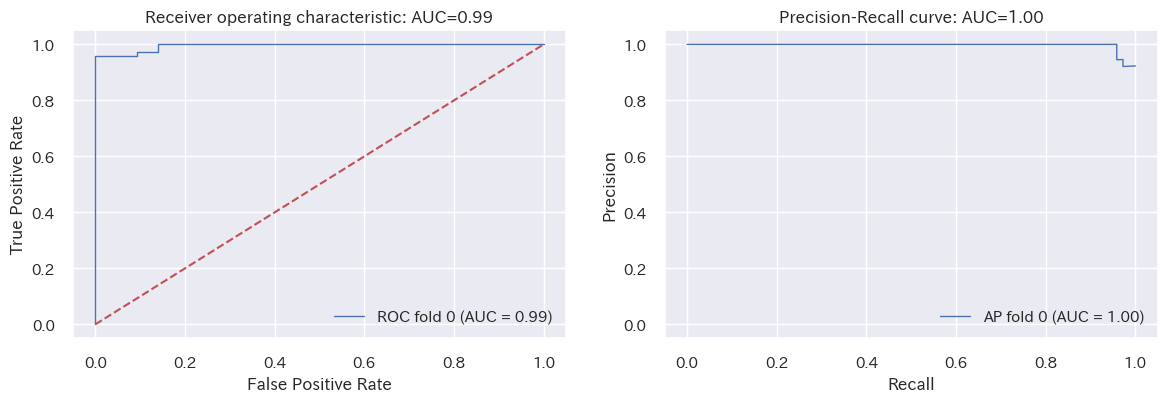

In [47]:
y_pred = ebm.predict_proba(X_test)[:, 1]
plot_roc_prerec(y_test, y_pred)

In [18]:
import plotly.offline as offline
import plotly.graph_objs as go

offline.init_notebook_mode(connected=False)

# 3. model analysis

## 3.1. EBM

-  EBM uses modern machine learning techniques like bagging and boosting to breathe new life into traditional GAMs (Generalized Additive Models). This makes them as accurate as random forests and gradient boosted trees, and also enhances their intelligibility and editability.

- 一般化加法モデル
    - https://logics-of-blue.com/%E5%B9%B3%E6%BB%91%E5%8C%96%E3%82%B9%E3%83%97%E3%83%A9%E3%82%A4%E3%83%B3%E3%81%A8%E5%8A%A0%E6%B3%95%E3%83%A2%E3%83%87%E3%83%AB/

https://www.microsoft.com/en-us/research/wp-content/uploads/2017/06/KDD2015FinalDraftIntelligibleModels4HealthCare_igt143e-caruanaA.pdf

### 3.1.0. histgram

In [19]:
import interpret
from interpret import show
from interpret.data import ClassHistogram

interpret.set_show_addr(("127.0.0.1", 6901))

hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')
show(hist)

<!-- http://127.0.0.1:6901/140347512012192/ -->

In [20]:
from interpret.data import Marginal

me = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(me)

<!-- http://127.0.0.1:6901/140347150750216/ -->

### 3.1.1. explain_global

In [21]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:6901/140347150749992/ -->

In [22]:
# show ではなく、apiで情報抽出する方法。

print(ebm_global._internal_obj['overall']['names'])

print(ebm_global._internal_obj['specific'][0]['density']['scores'])

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
[6, 34, 60, 113, 75, 50, 31, 27, 33, 14, 5, 1, 2, 3]


### 3.1.2. explain_local

In [23]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')
show(ebm_local)

<!-- http://127.0.0.1:6901/140347151117896/ -->

In [24]:
# show ではなく、apiで情報抽出する方法。

print(ebm_local._internal_obj['specific'][0])

{'type': 'univariate', 'names': ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension'], 'scores': [-0.49783484841894904, 0.7466852684336315, -0.6753156723286795, -0.5571747162512888, -0.3097097182675496, -0.30157434984588016, -0.4932425459607818, -0.6497139050129475, -0.08093158667396956, 0.036584161137114005, -0.543336525859614, -0.05725546682660291, -0.5949595417482879, -0.6246876186859681, -0.031605219111696004, 0.29790013113814917, -0.19319287200457141, -0.27517341261514

### 3.1.3. ROC

In [25]:
from interpret.perf import ROC

ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:6901/140347042095960/ -->

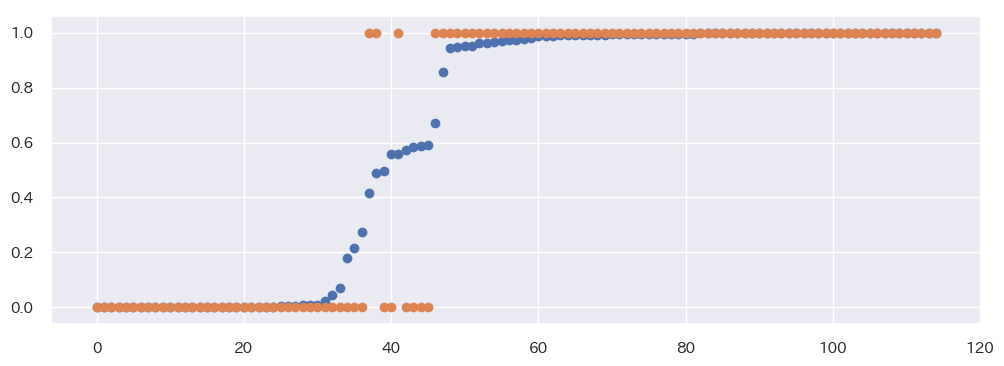

In [26]:
sns.set(font='IPAPGothic')
plt.figure(figsize=(12, 4))
tmp_y_test = y_test.values
tmp_y_pred = y_pred
plt.scatter(np.sort([np.argsort(tmp_y_pred)]), tmp_y_pred[np.argsort(tmp_y_pred)])
plt.scatter(np.sort([np.argsort(tmp_y_pred)]), tmp_y_test[np.argsort(tmp_y_pred)])
plt.show()

## 3.2. other models

- LR
- Tree

In [27]:
from interpret.glassbox import LogisticRegression, ClassificationTree
from sklearn.model_selection import train_test_split

seed = 1

# We have to transform categorical variables to use Logistic Regression and Decision Tree
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = list(X_enc.columns)
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)

lr = LogisticRegression(random_state=seed, feature_names=feature_names, penalty='l1', solver='liblinear')
lr.fit(X_train_enc, y_train)

tree = ClassificationTree()
tree.fit(X_train_enc, y_train)

In [28]:
X.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error  worst radius  worst texture  worst perimeter  worst area  worst smoothness  worst compactness  worst concavity  worst concave points  worst symmetry  worst fractal dimension
0        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871        1.0950         0.9053            8.589      153.40          0.006399            0.04904          0.05373               0.01587         0.03003                 0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890
1        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667        0.5435         0.7339            3.398       74.08          0.005225            0.01308          0.01860               0.01340         0.01389                 0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902
2        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999        0.7456         0.7869            4.585       94.03          0.006150            0.04006          0.03832               0.02058         0.02250                 0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758
3        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744        0.4956         1.1560            3.445       27.23          0.009110            0.07458          0.05661               0.01867         0.05963                 0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300
4        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883        0.7572         0.7813            5.438       94.44          0.011490            0.02461          0.05688               0.01885         0.01756                 0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678

In [29]:
X_enc.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error  worst radius  worst texture  worst perimeter  worst area  worst smoothness  worst compactness  worst concavity  worst concave points  worst symmetry  worst fractal dimension
0        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871        1.0950         0.9053            8.589      153.40          0.006399            0.04904          0.05373               0.01587         0.03003                 0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890
1        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667        0.5435         0.7339            3.398       74.08          0.005225            0.01308          0.01860               0.01340         0.01389                 0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902
2        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999        0.7456         0.7869            4.585       94.03          0.006150            0.04006          0.03832               0.02058         0.02250                 0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758
3        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744        0.4956         1.1560            3.445       27.23          0.009110            0.07458          0.05661               0.01867         0.05963                 0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300
4        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883        0.7572         0.7813            5.438       94.44          0.011490            0.02461          0.05688               0.01885         0.01756                 0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678

In [30]:
lr_perf = ROC(lr.predict_proba).explain_perf(X_test_enc, y_test, name='Logistic Regression')
tree_perf = ROC(tree.predict_proba).explain_perf(X_test_enc, y_test, name='Classification Tree')

show(lr_perf)
show(tree_perf)
show(ebm_perf)

<!-- http://127.0.0.1:6901/140347396334032/ -->

<!-- http://127.0.0.1:6901/140347041623288/ -->

<!-- http://127.0.0.1:6901/140347042095960/ -->

In [31]:
lr_global = lr.explain_global(name='LR')
tree_global = tree.explain_global(name='Tree')

show(lr_global)
show(tree_global)
show(ebm_global)

<!-- http://127.0.0.1:6901/140347041623176/ -->

<!-- http://127.0.0.1:6901/140347040947784/ -->

<!-- http://127.0.0.1:6901/140347150749992/ -->

In [32]:
tree_global._internal_obj

{'overall': {'type': 'tree',
  'features': ['mean radius',
   'mean texture',
   'mean perimeter',
   'mean area',
   'mean smoothness',
   'mean compactness',
   'mean concavity',
   'mean concave points',
   'mean symmetry',
   'mean fractal dimension',
   'radius error',
   'texture error',
   'perimeter error',
   'area error',
   'smoothness error',
   'compactness error',
   'concavity error',
   'concave points error',
   'symmetry error',
   'fractal dimension error',
   'worst radius',
   'worst texture',
   'worst perimeter',
   'worst area',
   'worst smoothness',
   'worst compactness',
   'worst concavity',
   'worst concave points',
   'worst symmetry',
   'worst fractal dimension'],
  'nodes': [{'data': {'id': '1',
     'label': 'worst perimeter <= 106.05\n# Obs: 170, 285',
     'feature': 'worst perimeter'}},
   {'data': {'id': '2',
     'label': 'worst concave points <= 0.16\n# Obs: 9, 262',
     'feature': 'worst concave points'}},
   {'data': {'id': '3',
     'label'

### 3.2.1. dashboard

- 順番は順不同っぽい

In [33]:
# Do everything in one shot with the InterpretML Dashboard by passing a list into show

show([hist, lr_global, lr_perf, tree_global, tree_perf, ebm_global, ebm_perf, ebm_local], share_tables=True)

<!-- http://127.0.0.1:6901/140347040654216/ -->
 Open in new window

## 3.3. blackbox model

- RandomForest

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
)

X = df.drop(columns=['target'])
y = df['target']

kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
train_index,test_index = next(kf.split(X, y))

X_train = X.iloc[train_index, :]
y_train = y[train_index]

X_test = X.iloc[test_index, :]
y_test = y[test_index]

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline



#Blackbox system can include preprocessing, not just a classifier!
pca = PCA()
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, wa

In [36]:
from interpret import show
from interpret.perf import ROC

blackbox_perf = ROC(blackbox_model.predict_proba).explain_perf(X_test, y_test, name='Blackbox')
show(blackbox_perf)

<!-- http://127.0.0.1:6901/140347041513424/ -->

### 3.3.1 local explain

- LIME
- SHAP

In [37]:
from interpret.blackbox import LimeTabular
from interpret import show

#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=blackbox_model.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:5], y_test[:5], name='LIME')

show(lime_local)

<!-- http://127.0.0.1:6901/140344339873128/ -->

In [38]:
from interpret.blackbox import ShapKernel
import numpy as np

background_val = np.median(X_train, axis=0).reshape(1, -1)
shap = ShapKernel(predict_fn=blackbox_model.predict_proba, data=background_val, feature_names=feature_names)
shap_local = shap.explain_local(X_test[:5], y_test[:5], name='SHAP')
show(shap_local)

A Jupyter Widget

<!-- http://127.0.0.1:6901/140346890633400/ -->

### 3.3.2 global explain

- MorrisSensitivity
    - https://salib.readthedocs.io/en/latest/
- PartialDependence
    - https://cran.r-project.org/web/packages/datarobot/vignettes/PartialDependence.html

In [39]:
from interpret.blackbox import MorrisSensitivity

sensitivity = MorrisSensitivity(predict_fn=blackbox_model.predict_proba, data=X_train)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")

show(sensitivity_global)

<!-- http://127.0.0.1:6901/140344322441512/ -->

In [40]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=blackbox_model.predict_proba, data=X_train)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

/home/kidnohr2000/.local/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/kidnohr2000/.local/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/kidnohr2000/.local/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/kidnohr2000/.local/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/kidnohr2000/.local/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



<!-- http://127.0.0.1:6901/140344336424744/ -->

In [41]:
show([blackbox_perf, lime_local, shap_local, sensitivity_global, pdp_global])

<!-- http://127.0.0.1:6901/140346966424136/ -->
 Open in new window

In [48]:
from interpret.blackbox import LimeTabular
from interpret import show

#Blackbox explainers need a predict function, and optionally a dataset
lime2 = LimeTabular(predict_fn=ebm.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local2 = lime2.explain_local(X_test[:5], y_test[:5], name='LIME2')

show(lime_local2)

<!-- http://127.0.0.1:6901/140344303445720/ -->

In [49]:
from interpret.blackbox import ShapKernel
import numpy as np

background_val = np.median(X_train, axis=0).reshape(1, -1)
shap2 = ShapKernel(predict_fn=ebm.predict_proba, data=background_val, feature_names=feature_names)
shap_local2 = shap2.explain_local(X_test[:5], y_test[:5], name='SHAP')
show(shap_local2)

A Jupyter Widget

<!-- http://127.0.0.1:6901/140347384747904/ -->